In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastcore.xtras import load_pickle

from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_photoswitch_smiles_pred, evaluate_generated_smiles

from gptchem.settings import ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH

from guacamol.utils.chemistry import is_valid
from glob import glob
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

import matplotx


%matplotlib inline

In [3]:
from rdkit import Chem

In [4]:
all_res = glob('out/**/*.pkl')

In [5]:
res = load_pickle(all_res[0])

In [6]:
from collections import defaultdict

In [8]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [43]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res['res_at_temp']:


        metrics= {
            'noise_level': res['noise_level'],
            'temp': temp_res['temperature'],
            'frac_valid': temp_res['frac_valid'],
            'frac_unique': temp_res['frac_unique'],
            'frac_smiles_in_train': temp_res['frac_smiles_in_train'],
            'frac_smiles_in_pubchem': temp_res['frac_smiles_in_pubchem'],
            'kld': temp_res['kld'],
            'frechet_d': temp_res['frechet_d'],
            'frechet_score': temp_res['frechet_score'],
            'frac_contains_azo': sum([contains_azo(s) for s in temp_res['valid_smiles']]) / len(temp_res['valid_smiles']),
        }

        generated_smiles.update([s for s in temp_res['generated_smiles'] if is_valid(s)])
        v_w_azo = [s for s in temp_res['generated_smiles'] if is_valid(s) and contains_azo(s)]
        generated_smiles_w_azos.update(v_w_azo)
        generated_smiles_w_azos_at_temp[temp_res['temperature']].update(v_w_azo)


        v = [s for s in temp_res['generated_smiles'] if is_valid(s)]
        generated_smiles_at_temp[temp_res['temperature']].update(v)

        for me, v in temp_res['e_pi_pi_star_metrics'].items():
            metrics["e_pi_pi_star_" + me] = v

        for me, v in temp_res['z_pi_pi_star_metrics'].items():
            metrics["z_pi_pi_star_" + me] = v
        compiled_res.append(metrics)

In [44]:
contains_azo(list(generated_smiles)[5])

False

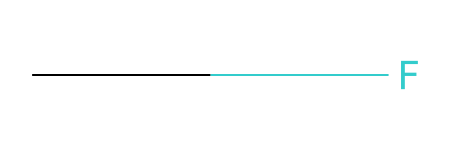

In [45]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [46]:
df = pd.DataFrame(compiled_res)

In [49]:
grouped = df.groupby(['temp', 'noise_level']).agg(['mean', 'std'])

In [50]:
grouped

frac_valid           frac_unique            \
                       mean       std        mean       std   
temp noise_level                                              
0.00 0.5           0.983696  0.023058    0.027723  0.008463   
     1.0           1.000000       NaN    0.021739       NaN   
     5.0           1.000000       NaN    0.021739       NaN   
     10.0          1.000000       NaN    0.021739       NaN   
0.10 0.5           0.989130  0.015372    0.060749  0.039796   
     1.0           1.000000       NaN    0.021739       NaN   
     5.0           1.000000       NaN    0.043478       NaN   
     10.0          0.978261       NaN    0.044444       NaN   
0.20 0.5           0.978261  0.030744    0.139822  0.059391   
     1.0           1.000000       NaN    0.119565       NaN   
     5.0           1.000000       NaN    0.076087       NaN   
     10.0          0.891304       NaN    0.097561       NaN   
0.50 0.5           0.983696  0.023058    0.364924  0.024180   
     1.0           0.978261       NaN    0.377778       NaN   
     5.0           0.967391       NaN    0.348315       NaN   
     10.0          0.934783       NaN    0.313953       NaN   
0.75 0.5           0.869565  0.000000    0.581250  0.026517   
     1.0           0.967391       NaN    0.550562       NaN   
     5.0           0.956522       NaN    0.522727       NaN   
     10.0          0.902174       NaN    0.566265       NaN   
1.00 0.5           0.673913  0.015372    0.710903  0.107455   
     1.0           0.663043       NaN    0.754098       NaN   
     5.0           0.663043       NaN    0.786885       NaN   
     10.0          0.641304       NaN    0.728814       NaN   
1.25 0.5           0.298913  0.053802    0.819892  0.019008   
     1.0           0.282609       NaN    0.884615       NaN   
     5.0           0.358696       NaN    0.969697       NaN   
     10.0          0.293478       NaN    0.925926       NaN   
1.50 0.5           0.103261  0.007686    1.000000  0.000000   
     1.0           0.141304       NaN    1.000000       NaN   
     5.0           0.054348       NaN    1.000000       NaN   
     10.0          0.108696       NaN    1.000000       NaN   
2.00 0.5           0.125000  0.038430    1.000000  0.000000   
     1.0           0.086957       NaN    1.000000       NaN   
     5.0           0.141304       NaN    1.000000       NaN   
     10.0          0.173913       NaN    1.000000       NaN   

                 frac_smiles_in_train      frac_smiles_in_pubchem            \
                                 mean  std                   mean       std   
temp noise_level                                                              
0.00 0.5                          0.0  0.0               1.000000  0.000000   
     1.0                          0.0  NaN               1.000000       NaN   
     5.0                          0.0  NaN               1.000000       NaN   
     10.0                         0.0  NaN               1.000000       NaN   
0.10 0.5                          0.0  0.0               1.000000  0.000000   
     1.0                          0.0  NaN               1.000000       NaN   
     5.0                          0.0  NaN               1.000000       NaN   
     10.0                         0.0  NaN               1.000000       NaN   
0.20 0.5                          0.0  0.0               1.000000  0.000000   
     1.0                          0.0  NaN               1.000000       NaN   
     5.0                          0.0  NaN               1.000000       NaN   
     10.0                         0.0  NaN               1.000000       NaN   
0.50 0.5                          0.0  0.0               1.000000  0.000000   
     1.0                          0.0  NaN               1.000000       NaN   
     5.0                          0.0  NaN               1.000000       NaN   
     10.0                         0.0  NaN               1.000000       NaN   
0.75 0.5                          0.0  0.0               1

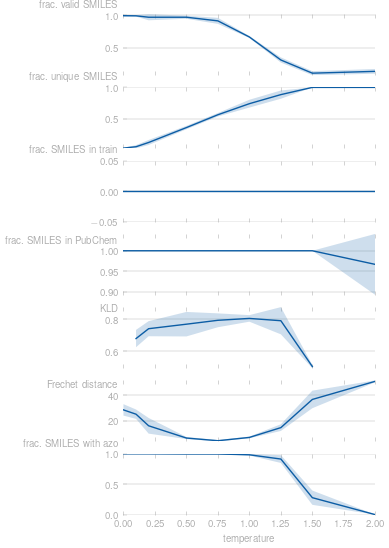

In [15]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(7,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, 2*ONE_COL_WIDTH_INCH))
    ax[0].plot(grouped.index, grouped['frac_valid']['mean'], label='frac_valid')
    ax[0].fill_between(grouped.index, grouped['frac_valid']['mean'] - grouped['frac_valid']['std'], grouped['frac_valid']['mean'] + grouped['frac_valid']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. valid SMILES', ax=ax[0])

    ax[1].plot(grouped.index, grouped['frac_unique']['mean'], label='frac_unique')
    ax[1].fill_between(grouped.index, grouped['frac_unique']['mean'] - grouped['frac_unique']['std'], grouped['frac_unique']['mean'] + grouped['frac_unique']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. unique SMILES', ax=ax[1])

    ax[2].plot(grouped.index, grouped['frac_smiles_in_train']['mean'], label='frac_smiles_in_train')
    ax[2].fill_between(grouped.index, grouped['frac_smiles_in_train']['mean'] - grouped['frac_smiles_in_train']['std'], grouped['frac_smiles_in_train']['mean'] + grouped['frac_smiles_in_train']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES in train', ax=ax[2])

    ax[3].plot(grouped.index, grouped['frac_smiles_in_pubchem']['mean'], label='frac_smiles_in_pubchem')
    ax[3].fill_between(grouped.index, grouped['frac_smiles_in_pubchem']['mean'] - grouped['frac_smiles_in_pubchem']['std'], grouped['frac_smiles_in_pubchem']['mean'] + grouped['frac_smiles_in_pubchem']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES in PubChem', ax=ax[3])

    ax[4].plot(grouped.index, grouped['kld']['mean'], label='kld')
    ax[4].fill_between(grouped.index, grouped['kld']['mean'] - grouped['kld']['std'], grouped['kld']['mean'] + grouped['kld']['std'], alpha=0.2)

    matplotx.ylabel_top('KLD', ax=ax[4])

    ax[5].plot(grouped.index, grouped['frechet_d']['mean'], label='frechet_d')
    ax[5].fill_between(grouped.index, grouped['frechet_d']['mean'] - grouped['frechet_d']['std'], grouped['frechet_d']['mean'] + grouped['frechet_d']['std'], alpha=0.2)

    matplotx.ylabel_top('Frechet distance', ax=ax[5])

    ax[6].plot(grouped.index, grouped['frac_contains_azo']['mean'], label='frechet_score')
    ax[6].fill_between(grouped.index, grouped['frac_contains_azo']['mean'] - grouped['frac_contains_azo']['std'], grouped['frac_contains_azo']['mean'] + grouped['frac_contains_azo']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES with azo', ax=ax[6])

    ax[-1].set_xlabel('temperature', labelpad=4)

    fig.savefig('photoswitch_random_smiles_metrics.pdf', bbox_inches='tight')

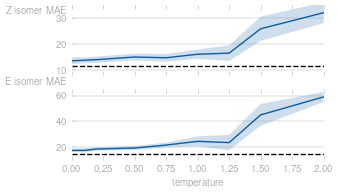

In [32]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(2,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

    ax[0].plot(grouped.index, grouped['z_pi_pi_star_mean_absolute_error']['mean'], label='e_pi_pi_star_metrics')
    ax[0].fill_between(grouped.index, grouped['z_pi_pi_star_mean_absolute_error']['mean'] - grouped['z_pi_pi_star_mean_absolute_error']['std'], grouped['z_pi_pi_star_mean_absolute_error']['mean'] + grouped['z_pi_pi_star_mean_absolute_error']['std'], alpha=0.2)

    matplotx.ylabel_top('Z isomer MAE', ax=ax[0])

    ax[0].hlines(11.616605626696359, 0, 2, color='k', linestyle='--')

    ax[0].set_ylim(8,35)

    ax[1].plot(grouped.index, grouped['e_pi_pi_star_mean_absolute_error']['mean'], label='e_pi_pi_star_metrics')
    ax[1].fill_between(grouped.index, grouped['e_pi_pi_star_mean_absolute_error']['mean'] - grouped['e_pi_pi_star_mean_absolute_error']['std'], grouped['e_pi_pi_star_mean_absolute_error']['mean'] + grouped['e_pi_pi_star_mean_absolute_error']['std'], alpha=0.2)

    matplotx.ylabel_top('E isomer MAE', ax=ax[1])

    ax[1].hlines(14.38998132190228, 0, 2, color='k', linestyle='--')

    ax[-1].set_xlabel('temperature', labelpad=4)
    ax[1].set_ylim(10,65)
fig.savefig('random_photoswitch_constrain_matches.pdf', bbox_inches='tight')

## Visualize

In [18]:
import tmap as tm
import numpy as np

from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem

from tqdm import tqdm

In [23]:
import os
import shutil

In [51]:
def make_figure(temp):
    path = f"plots_all/{temp}"
    os.mkdir(path)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data['SMILES'].values
    all_smiles = set(train_smiles) | generated_smiles_at_temp[temp]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        labels.append(smiles in train_smiles)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
    clear_color="#FFFFFF",
    coords=False,
    view="free",
    impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set1",
        categorical=True,
        shader='sphere',
        has_legend=True,
        point_scale=5,
        legend_labels=[(1, "in database"), (0, "not in database")],
        max_point_size=5000
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [52]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

FileExistsError: [Errno 17] File exists: 'plots_all/0'

In [55]:
make_figure(1.5)

100%|██████████| 440/440 [00:04<00:00, 93.61it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html